# **Packages**  

In [8]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE

# **Preparing the samples**

In [9]:
with open("amazon_new400_samples.pkl","rb") as f:
    amazon_samples400 = pickle.load(f)

print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

## **Null values of City**

In [10]:
null_cities = amazon_samples400[amazon_samples400["City"].isna()]

coordinates_null_cities = null_cities[["abs_Store_Latitude","abs_Store_Longitude"]]
print(coordinates_null_cities)

       abs_Store_Latitude  abs_Store_Longitude
3000            18.593481            73.785901
35977           18.593481            73.785901
17423           17.433809            78.386744
15852           21.183434            72.814492
30932           11.022169            76.999594


In [13]:
from geopy.geocoders import Nominatim
from modules_amazon import Location
import time
cities = []
for lat,long in zip(coordinates_null_cities["abs_Store_Latitude"],\
                    coordinates_null_cities["abs_Store_Longitude"]):
    loc=Location(lat,long)
    cities.append(loc.city())
    time.sleep(1)


In [14]:
cities

['Pimpri-Chinchwad', 'Pimpri-Chinchwad', 'Hyderabad', 'Surat', '']

In [15]:
amazon_samples400["City"] = amazon_samples400["City"].fillna(pd.Series(cities,\
                            index=amazon_samples400[amazon_samples400["City"].isna()].index))
print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order_ID                400 non-null    object        
 1   Agent_Age               400 non-null    int64         
 2   Agent_Rating            400 non-null    float64       
 3   Drop_Latitude           400 non-null    float64       
 4   Drop_Longitude          400 non-null    float64       
 5   Order_Date              400 non-null    datetime64[ns]
 6   Order_Time              400 non-null    object        
 7   Pickup_Time             400 non-null    object        
 8   Weather                 400 non-null    category      
 9   Traffic                 400 non-null    category      
 10  Vehicle                 400 non-null    category      
 11  Area                    400 non-null    category      
 12  Delivery_Time           400 non-null    int64    

### **Quick evaluation of City**

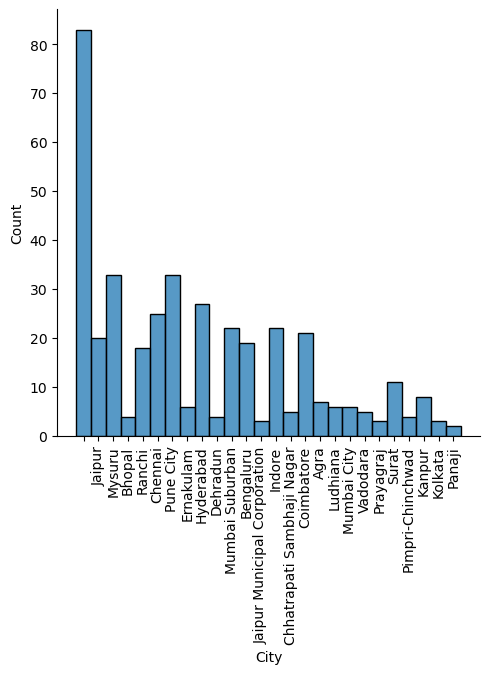

In [16]:
sns.displot(amazon_samples400["City"])
plt.xticks(rotation=90)
plt.show()

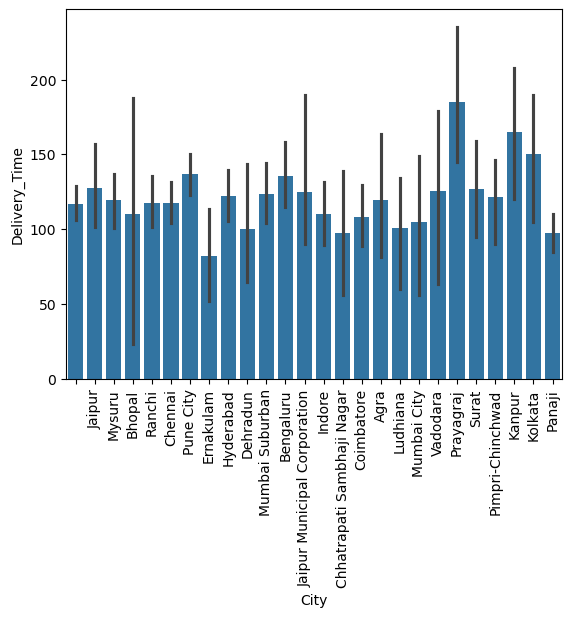

In [17]:
sns.barplot(x="City", y="Delivery_Time", data=amazon_samples400)
plt.xticks(rotation=90)
plt.show()

## **Making an Order_weekday column**

In [18]:
print(amazon_samples400["Order_Date"].min(), amazon_samples400["Order_Date"].max())

2022-02-11 00:00:00 2022-04-06 00:00:00


In [19]:
amazon_samples400["Order_Weekday"] = amazon_samples400["Order_Date"].dt.weekday
amazon_samples400 = amazon_samples400.drop("Order_Date", axis=1)
print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                400 non-null    object  
 1   Agent_Age               400 non-null    int64   
 2   Agent_Rating            400 non-null    float64 
 3   Drop_Latitude           400 non-null    float64 
 4   Drop_Longitude          400 non-null    float64 
 5   Order_Time              400 non-null    object  
 6   Pickup_Time             400 non-null    object  
 7   Weather                 400 non-null    category
 8   Traffic                 400 non-null    category
 9   Vehicle                 400 non-null    category
 10  Area                    400 non-null    category
 11  Delivery_Time           400 non-null    int64   
 12  Category                400 non-null    object  
 13  Distance_Store_Drop_km  400 non-null    float64 
 14  abs_Store_Latitude      4

## **Switching to a column Order_Time_hour**

In [20]:
amazon_samples400["Order_Time"] = pd.to_datetime(amazon_samples400["Order_Time"])
amazon_samples400["Order_Time_hour"] = amazon_samples400["Order_Time"].dt.hour
amazon_samples400 = amazon_samples400.drop(["Order_Time","Pickup_Time"], axis=1)
print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                400 non-null    object  
 1   Agent_Age               400 non-null    int64   
 2   Agent_Rating            400 non-null    float64 
 3   Drop_Latitude           400 non-null    float64 
 4   Drop_Longitude          400 non-null    float64 
 5   Weather                 400 non-null    category
 6   Traffic                 400 non-null    category
 7   Vehicle                 400 non-null    category
 8   Area                    400 non-null    category
 9   Delivery_Time           400 non-null    int64   
 10  Category                400 non-null    object  
 11  Distance_Store_Drop_km  400 non-null    float64 
 12  abs_Store_Latitude      400 non-null    float64 
 13  abs_Store_Longitude     400 non-null    float64 
 14  City                    4

C:\Users\Angelique\AppData\Local\Temp\ipykernel_17204\78744661.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  amazon_samples400["Order_Time"] = pd.to_datetime(amazon_samples400["Order_Time"])


## **Checking category**  
With the previous samples, I found that the category Grocery had a significant lower Delivery_time compared to all the other categories which didn't seem different from from each other.  
I will look here whether I have the same pattern here.

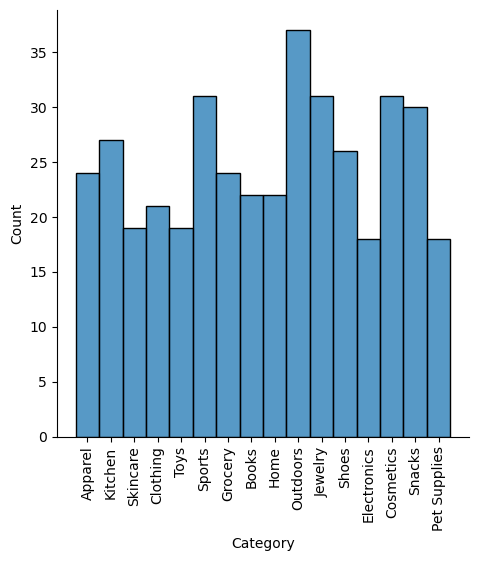

In [21]:
sns.displot(amazon_samples400["Category"])
plt.xticks(rotation=90)
plt.show()

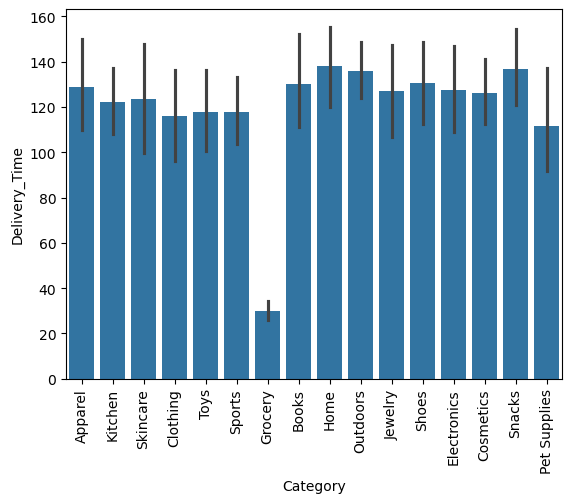

In [22]:
sns.barplot(x="Category", y="Delivery_Time", data=amazon_samples400)
plt.xticks(rotation=90)
plt.show()

I can still see the drastic difference.

## **Dropping the unecessary columns**

In [23]:
print(amazon_samples400.info())

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 43442 to 30932
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                400 non-null    object  
 1   Agent_Age               400 non-null    int64   
 2   Agent_Rating            400 non-null    float64 
 3   Drop_Latitude           400 non-null    float64 
 4   Drop_Longitude          400 non-null    float64 
 5   Weather                 400 non-null    category
 6   Traffic                 400 non-null    category
 7   Vehicle                 400 non-null    category
 8   Area                    400 non-null    category
 9   Delivery_Time           400 non-null    int64   
 10  Category                400 non-null    object  
 11  Distance_Store_Drop_km  400 non-null    float64 
 12  abs_Store_Latitude      400 non-null    float64 
 13  abs_Store_Longitude     400 non-null    float64 
 14  City                    4

In [24]:
df_model = amazon_samples400.drop(["Order_ID","City"], axis=1)

## **Make the dummies and setting the features and dependent variable**

In [25]:
amazon_dummies = pd.get_dummies(df_model, drop_first=True)

In [26]:
X = amazon_dummies.drop("Delivery_Time", axis=1).values
y = amazon_dummies["Delivery_Time"].values

## **Train and test sample**

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2013)

# **Finding the best model**  
Our dependent variable is continuous. I will therefore compare a linear regression model, Ridge and a decision tree Regressor.  
I don't need to standardize the data as they already are at the same scale.

In [28]:
print(X_train.shape)

(280, 38)


c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+02, tolerance: 6.281e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Angelique\anaconda3\envs\Essai\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.766e+01, tolerance: 6.088e+01
  model = cd_fast.enet_coordinate_descent(


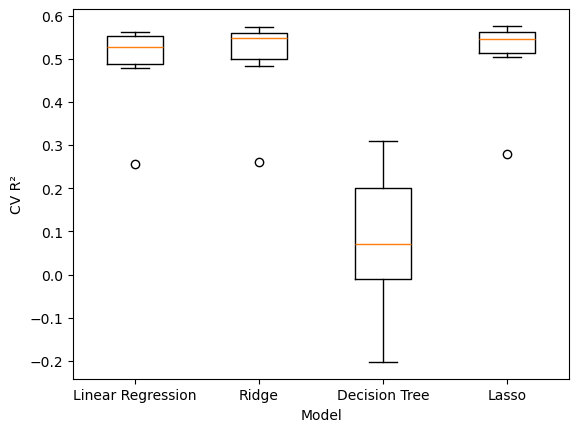

In [29]:
LinearReg = LinearRegression()
DecTree = DecisionTreeRegressor(max_depth=18, min_samples_leaf=0.05, max_features="sqrt", random_state=2013)
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha = 0.1)

models = {"Linear Regression":LinearReg, "Ridge":ridge, "Decision Tree":DecTree, "Lasso":lasso}

from modules import visu_cv_score

visu_cv_score(models,X_train,y_train)


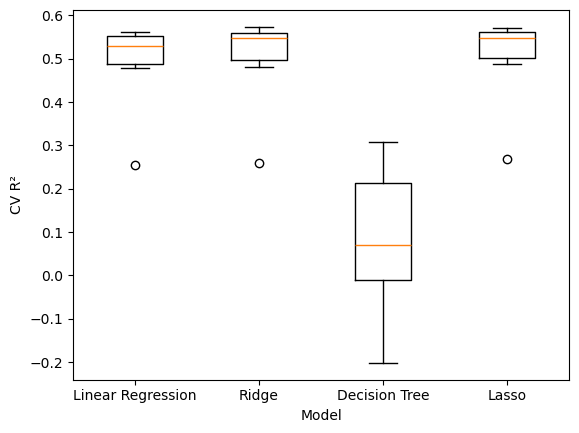

In [30]:
standard_Scale = StandardScaler()
X_train_scaled = standard_Scale.fit_transform(X_train)
X_test_scaled = standard_Scale.transform(X_test)

visu_cv_score(models,X_train_scaled,y_train)

In [31]:
from modules import rmse_regression_models

rmse_regression_models(models,X_train,y_train,X_test,y_test)

Linear Regression Test set rmse: 35.76404448955233
Ridge Test set rmse: 35.74064101275427
Decision Tree Test set rmse: 47.911781389193926
Lasso Test set rmse: 35.637766364434775


Although none of them are at this stage great, Lasso would be the best algorithm to tune.

# **Lasso hyperparamater tuning**